# Model comparison

In [1]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/configparser.py:316: UserWarning: PyTensor does not recognise this flag: blas_ldflags
  warnings.warn(f"PyTensor does not recognise this flag: {key}")


In [19]:
filepath = "../../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath).drop(columns=['special'])
df = df.dropna()

idata_non_interactions = az.from_netcdf('./bm_covariates.nc')
idata_interactions = az.from_netcdf('./bm_covariates_interactions.nc')

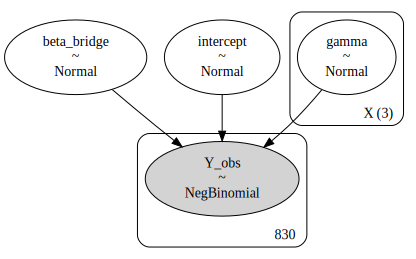

In [20]:
population = df['population']
bridge = df['dummy_after_bridge_opened']
income = df['income']
log_income = np.log(income)
area = df['area_km2']
log_area = np.log(area)
distance = df['distance_m']
log_distance = np.log(distance)

X = np.array([log_income, log_area, log_distance])

# 過分散パラメータ
mean_population = np.mean(population)
var_population = np.var(population)

alpha = (var_population - mean_population) / mean_population**2

with pm.Model() as model_non_interactions:
    # 事前分布
    intercept = pm.Normal('intercept', mu=6.4, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0.6, sigma=100)
    gamma = pm.Normal('gamma', mu=0, sigma=100, shape=3, dims='X')

    # 対数リンク関数
    lambda_ = pm.math.exp(intercept + beta_bridge * bridge + pm.math.dot(X.T, gamma))

    # 尤度
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lambda_, alpha=alpha, observed=population)


# モデルの視覚化
pm.model_to_graphviz(model_non_interactions)

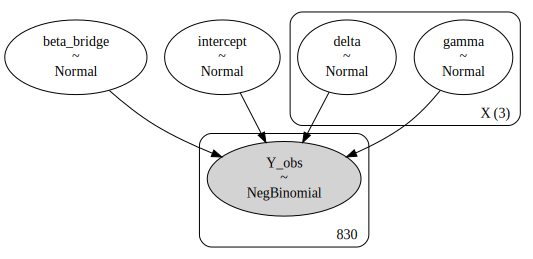

In [24]:
population = df['population']
bridge = df['dummy_after_bridge_opened']
income = df['income']
log_income = np.log(income)
area = df['area_km2']
log_area = np.log(area)
distance = df['distance_m']
log_distance = np.log(distance)

X = np.array([log_income, log_area, log_distance])

# 過分散パラメータ
mean_population = np.mean(population)
var_population = np.var(population)

alpha = (var_population - mean_population) / mean_population**2

bridge = np.array(bridge)
bridge[:, np.newaxis].shape

with pm.Model() as model_interactions:
    # 事前分布
    intercept = pm.Normal('intercept', mu=6.3, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0.5, sigma=100)
    gamma = pm.Normal('gamma', mu=0, sigma=100, shape=3, dims='X')
    delta = pm.Normal('delta', mu=0, sigma=100, shape=3, dims='X')

    # 交差項の計算
    interaction = bridge * X

    # 対数リンク関数
    lambda_ = pm.math.exp(intercept + beta_bridge * bridge + pm.math.dot(X.T, gamma) + pm.math.dot(interaction.T, delta))

    # 尤度
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lambda_, alpha=alpha, observed=population)


# モデルの視覚化
pm.model_to_graphviz(model_interactions)

## Model log likelihood

In [27]:
with model_non_interactions:
    pm.compute_log_likelihood(idata_non_interactions)

Output()

ValueError: ['log_likelihood'] group(s) already exists.

In [29]:
with model_interactions:
    pm.compute_log_likelihood(idata_interactions)

Output()

In [30]:
non_interactions_loo = az.loo(idata_non_interactions)
interactions_loo = az.loo(idata_interactions)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [31]:
df_comp_loo = az.compare({"non interactions": idata_non_interactions, "interactions": idata_interactions})
df_comp_loo

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
interactions,0,-7811.498239,58.895930,0.000000,0.542324,161.381651,0.000000,False,log
non interactions,1,-7901.048399,45.538455,89.550161,0.457676,177.871882,47.023886,True,log
